# GR 5221 Final Project

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Section 1: Exloratory Analysis

### 1.1 Load Data

In [2]:
df =  pd.read_csv('all_stocks_5yr.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [3]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

### 1.2 Reframe the dataframe
- Choose company `AAL` only
- Choose column `date` and `close`

In [4]:
AAL = df[df['Name'] == 'AAL']
ALL_1 = AAL.loc[:, ['date', 'close']]
ALL_1['date'] = pd.to_datetime(ALL_1['date'], format="%Y/%m/%d")
ALL_1.head()

,date,close
0,2013-02-08,14.75
1,2013-02-11,14.46
2,2013-02-12,14.27
3,2013-02-13,14.66
4,2013-02-14,13.99


There is no null value in the dataframe.

In [5]:
ALL_1.isnull().sum()

date     0
close    0
dtype: int64

### 1.3 Visualization

Text(0.5, 1.0, 'All Close Price History Of AAL')

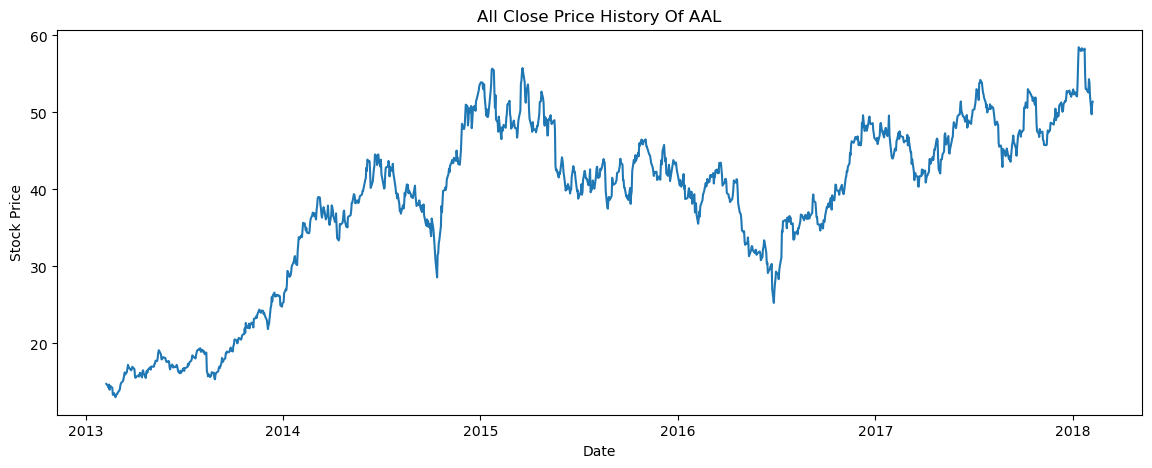

In [6]:
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(ALL_1['date'], ALL_1['close'])
ax.set_xlabel("Date")
ax.set_ylabel("Stock Price")
ax.set_title("All Close Price History Of AAL")

As the following plot, the original series is non-stationary.

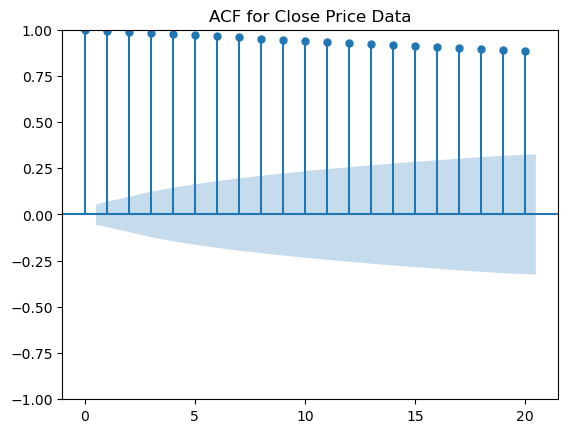

In [7]:
plot_acf(ALL_1.close, lags = 20, title="ACF for Close Price Data");

### 1.4 Train-Test Split

In [41]:
# ALL_1.date

In [42]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(ALL_1.date, ALL_1.close, test_size=0.2, random_state=42)

## Section 2: Time Series Model and Modeling Process 
### 2.1 AR(1) and MA(1)

In [85]:
from statsmodels.tsa.arima.model import ARIMA
# model1 is AR(1)
model1 = ARIMA(ALL_1.close, order = (1,0,0))
# model2 is MA(1)
model2 = ARIMA(ALL_1.close, order = (0,0,1))
model_fit1 = model1.fit()
model_fit2 = model2.fit()

/Users/wanghan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


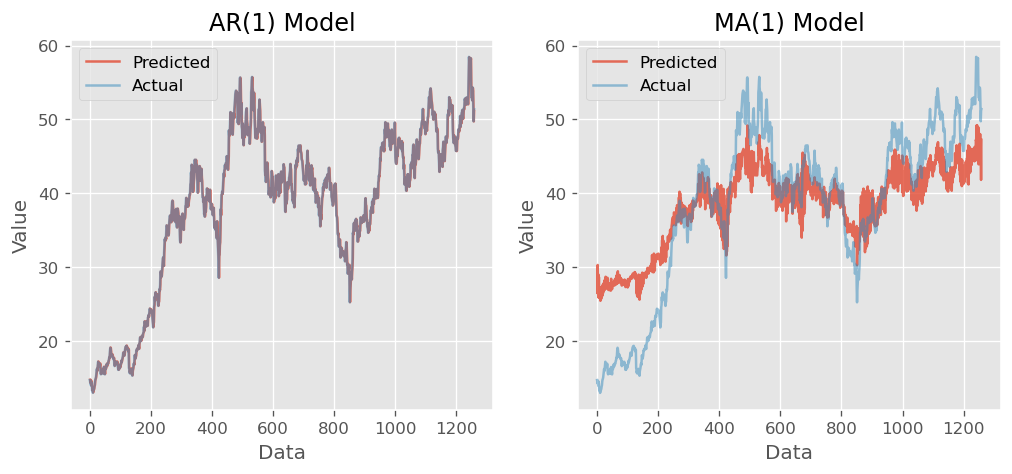

In [86]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pred1 = model_fit1.predict(dynamic = False)
pred2 = model_fit2.predict(dynamic = False)
plt.style.use('ggplot')

# plot actual values and predicted values
ax1.plot(pred1[1:], label='Predicted', alpha = 0.8)
ax1.plot(ALL_1.close, label='Actual', alpha = 0.5)
ax1.set_title('AR(1) Model')
ax1.set_xlabel('Data')
ax1.set_ylabel('Value')
ax1.legend()


ax2.plot(pred2[1:], label='Predicted', alpha = 0.8)
ax2.plot(ALL_1.close, label='Actual', alpha = 0.5)
ax2.set_title('MA(1) Model')
ax2.set_xlabel('Data')
ax2.set_ylabel('Value')
ax2.legend()

plt.show()

The lower the value of the Root Mean Squared Error, the better the model is.(...)

In [22]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(ALL_1.close[1:], pred1[1:]))
rmse2 = np.sqrt(mean_squared_error(ALL_1.close[1:], pred2[1:]))
print(f'The Root Mean Squared Error for AR(1) model is {rmse}\nThe Root Mean Squared Error for MA(1) model is {rmse2}')

The Root Mean Squared Error for AR(1) model is 0.8656642640183356
The Root Mean Squared Error for MA(1) model is 5.786038561783704


### 2.3 ARIMA

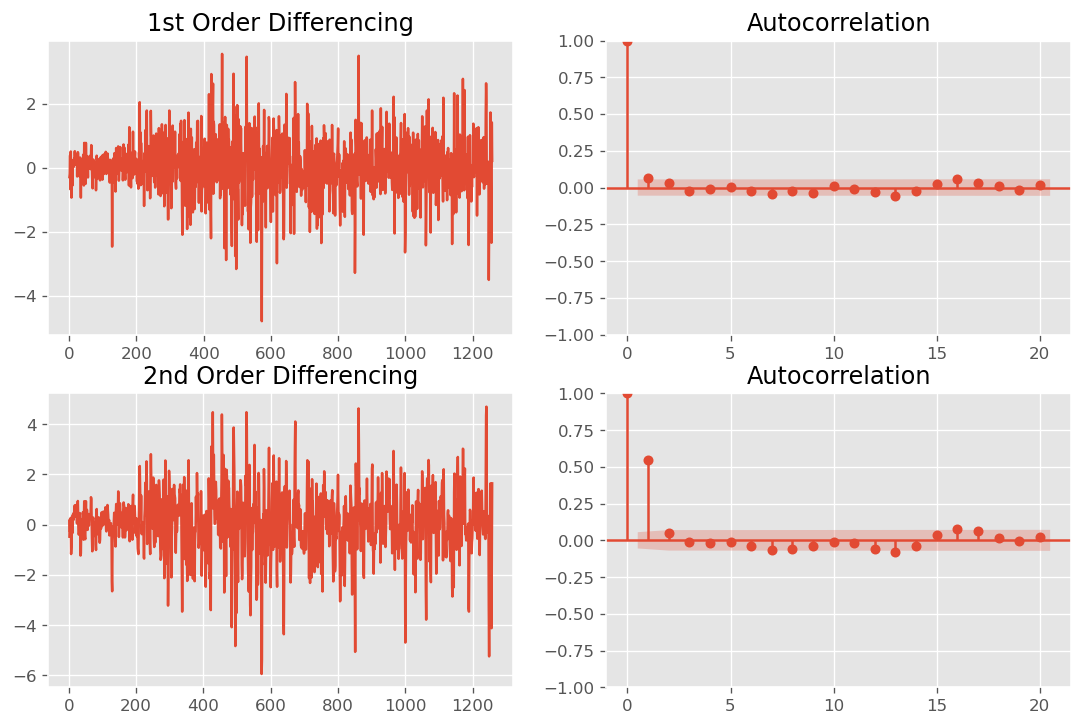

In [10]:
plt.rcParams.update({'figure.figsize': (11,7), 'figure.dpi': 120})
fig, axes = plt.subplots(2, 2)

# 1st Differencing
axes[0, 0].plot(ALL_1.close.diff()); axes[0,0].set_title('1st Order Differencing')
plot_acf(ALL_1.close.diff().dropna(), ax=axes[0,1], lags=20);

# 2nd Differencing
axes[1, 0].plot(ALL_1.close.diff(2)); axes[1,0].set_title('2nd Order Differencing')
plot_acf(ALL_1.close.diff(2).dropna(), ax=axes[1,1], lags=20);

- From above plots, we can see that the time series reaches stationarity with one orders of differencing.

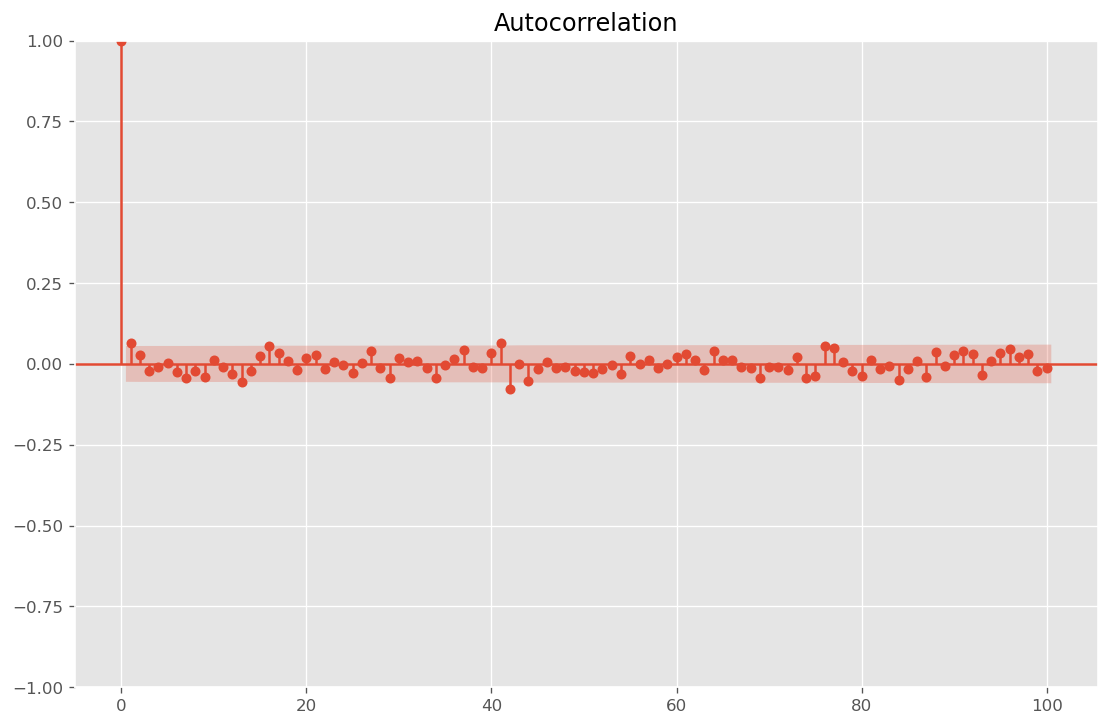

In [99]:
plot_acf(ALL_1.close.diff().dropna(), lags=100);

- Form the ACF plot, we can choose q = 100

/Users/wanghan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


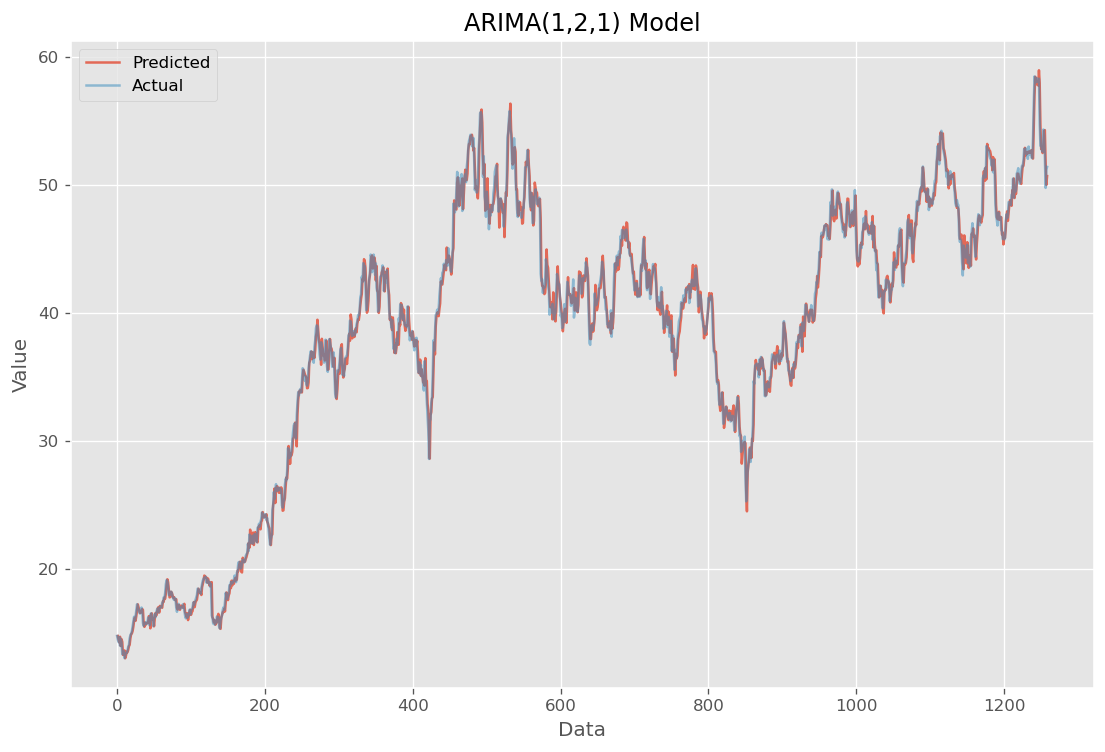

In [100]:
model3 = ARIMA(ALL_1.close, order = (1,1,100))
model_fit3 = model3.fit()
pred3 = model_fit3.predict(dynamic = False)
plt.style.use('ggplot')

plt.plot(pred3[1:], label='Predicted', alpha = 0.8)
plt.plot(ALL_1.close, label='Actual', alpha = 0.5)
plt.title('ARIMA(1,1,100) Model')
plt.xlabel('Data')
plt.ylabel('Value')
plt.legend()


In [101]:
rmse3 = np.sqrt(mean_squared_error(ALL_1.close[1:], pred3[1:]))
rmse3

0.8192939870490701

In [102]:
result = {'Model' : ['AR(1)', 'MA(1)', 'ARMA(1,2,1)'],
          'RMSE' : [rmse, rmse2, rmse3]}
pd.DataFrame(result)

,Model,RMSE
0,AR(1),0.865664
1,MA(1),5.786039
2,"ARMA(1,2,1)",0.819294


## Section 3: Model Validation

### 3.1 AIC

### 3.2 BIC

## Section 4: Forecasting

### 4.1 Forecasting using ARIMA

### 4.2 Forecasting using LSTM

## Section 5: ~